<a href="https://colab.research.google.com/github/johannes-kk/am207/blob/master/exercises/05_introduction_to_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAY 5: Introduction to Sampling


### AM207: Advanced Scientific Computing

#### Instructor: Weiwei Pan

#### Due: September 17th, 11:59pm EST

**Names of Group Members**: ___________
Will Seaton: wseaton@g.harvard.edu, Zhenwei(Selina) Wu: zwu2@g.harvard.edu, Stephanie Zhang (stephaniezhang@g.harvard.edu), Johannes Kolberg – johanneskolberg@g.harvard.edu, Daniel Cox daniel_cox@g.harvard.edu, Varun Tekur (v_tekur@college.harvard.edu)

## Learning Goals:

1. develop intuitive for the factors that impact the efficiency of rejection samplers
2. practice using sampling for Bayesian inference


### Load necessary libraries

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
%matplotlib inline

## Problem 1: Efficiency of Rejection Sampling 

In this problem, you'll explore the efficiency and correctness of rejection sampling.

**Exercise 1:** For the example in lecture where we simulate a univariate normal random variable using an exponential random variable, perform rejection sampling with a range of values of $M$, $M=0.1, 0.2, 0.5, 1, 2, 10, 50$. 

For which values of $M$ is rejection sampling theoretically gauranteed to be valid? Empirically, for which M do we get the best estimate of the mean and variance of the target distribution running rejection sampling 500 times. 

Why do some values of $M$ give us better estimates of the moments of the target distribution?

In [ ]:
#target distribution
target_pdf = sp.stats.norm(loc=0, scale=1).pdf
#proposal distirbution
proposal_pdf = sp.stats.expon(scale=1 / 0.5).pdf
#scaling constant
M = 2

#total number of iterations of rejection sampling
N = 1000
samples = []
#repeat rejection sampling until total number of samples is attained
for i in range(N):
    #sample x from proposal distribution
    proposed_sample = sp.stats.expon.rvs(scale=1 / 0.5, size=1)
    #sample a random height at x
    u = np.random.uniform(0, 1)
    #accept if height is below target distribution
    #remember that we are comparing the exponential distribution to the right half of the normal pdf
    #so we need to scale the normal pdf by a factor of 2 to make it a proper pdf over the nonnegative numbers
    if u < 2* target_pdf( proposed_sample) / (M * proposal_pdf(proposed_sample)):
        #if we are accepting randomly append a negative sign to the sample
        samples.append(proposed_sample * np.random.choice([-1, 1], size=1))
        
samples = np.array(samples)

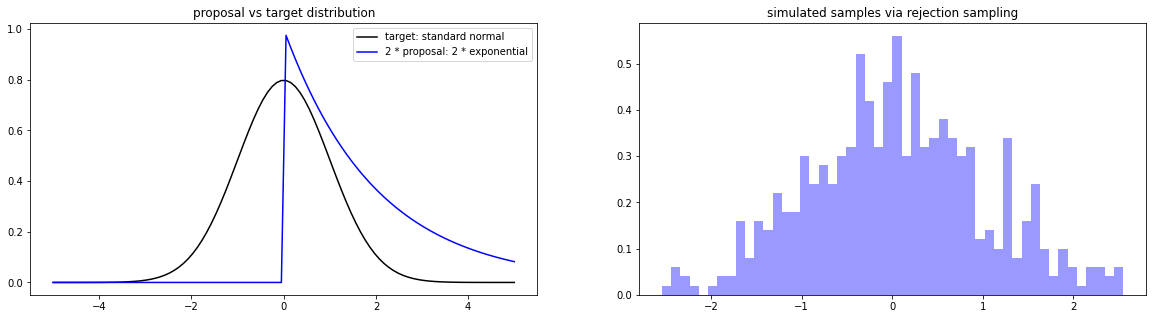

In [ ]:
#plot samples
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
x = np.linspace(-5, 5, 100)
ax[0].plot(x, 2 * target_pdf(x), color='black', label='target: standard normal')
ax[0].plot(x, M * proposal_pdf(x), color='blue', label='{} * proposal: {} * exponential'.format(M, M))
ax[0].set_title('proposal vs target distribution')
ax[0].legend(loc='best')
ax[1].hist(samples, bins=50, density=True, color='blue', alpha=0.4)
ax[1].set_title('simulated samples via rejection sampling')
plt.show()   

In [ ]:
# function to pla with sampler
def run_rej_sampler(M):
  #target distribution
  target_pdf = sp.stats.norm(loc=0, scale=1).pdf
  #proposal distirbution
  proposal_pdf = sp.stats.expon(scale=1 / 0.5).pdf
  #scaling constant
  M = M

  #total number of iterations of rejection sampling
  N = 1000
  samples = []
  #repeat rejection sampling until total number of samples is attained
  for i in range(N):
      #sample x from proposal distribution
      proposed_sample = sp.stats.expon.rvs(scale=1 / 0.5, size=1)
      #sample a random height at x
      u = np.random.uniform(0, 1)
      #accept if height is below target distribution
      #remember that we are comparing the exponential distribution to the right half of the normal pdf
      #so we need to scale the normal pdf by a factor of 2 to make it a proper pdf over the nonnegative numbers
      if u < 2* target_pdf(proposed_sample) / (M * proposal_pdf(proposed_sample)):
          #if we are accepting randomly append a negative sign to the sample
          samples.append(proposed_sample * np.random.choice([-1, 1], size=1))
          
  samples = np.array(samples)

  #plot samples
  fig, ax = plt.subplots(1, 2, figsize=(20, 5))
  x = np.linspace(-5, 5, 100)
  ax[0].plot(x, 2 * target_pdf(x), color='black', label='target: standard normal')
  ax[0].plot(x, M * proposal_pdf(x), color='blue', label='{} * proposal: {} * exponential'.format(M, M))
  ax[0].set_title('proposal vs target distribution')
  ax[0].legend(loc='best')
  ax[1].hist(samples, bins=50, density=True, color='blue', alpha=0.4)
  ax[1].set_title('simulated samples via rejection sampling')
  plt.show() 
  print(f'Percent accepted samples = {len(samples)/N*100}')  


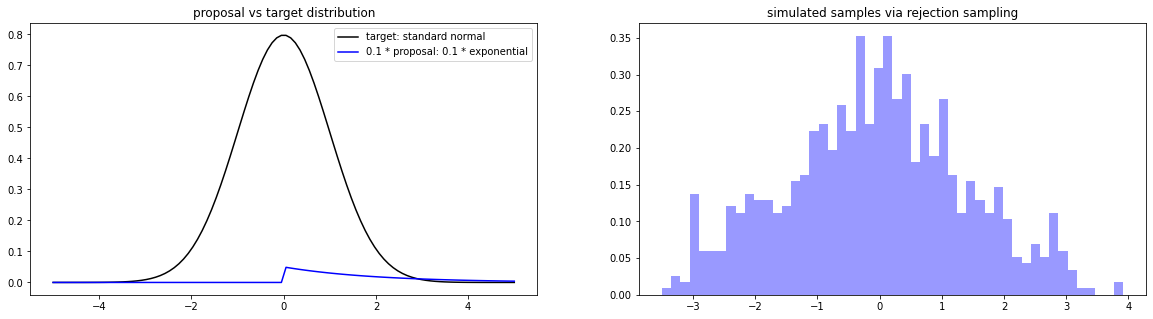

Percent accepted samples = 78.4


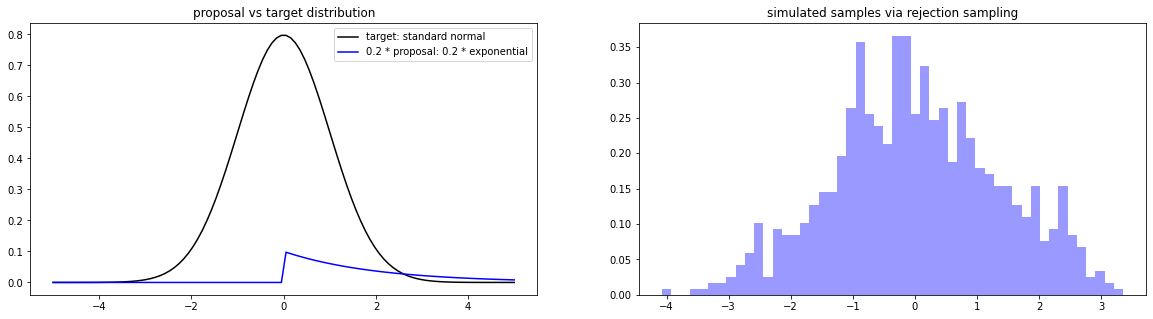

Percent accepted samples = 79.10000000000001


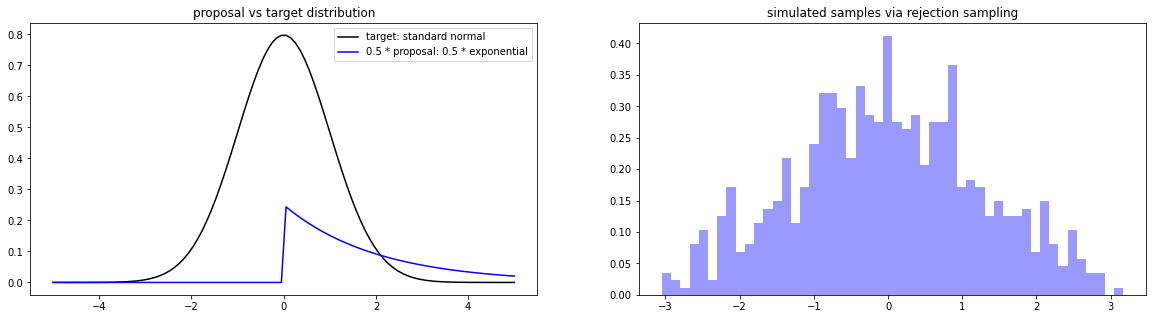

Percent accepted samples = 70.3


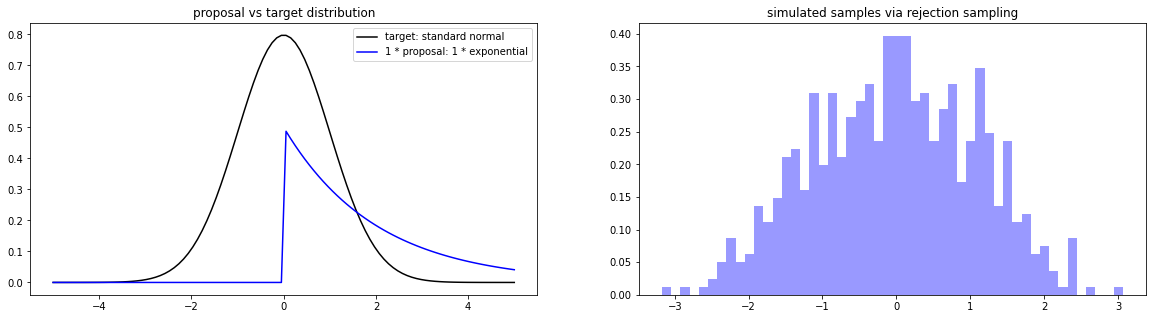

Percent accepted samples = 64.60000000000001


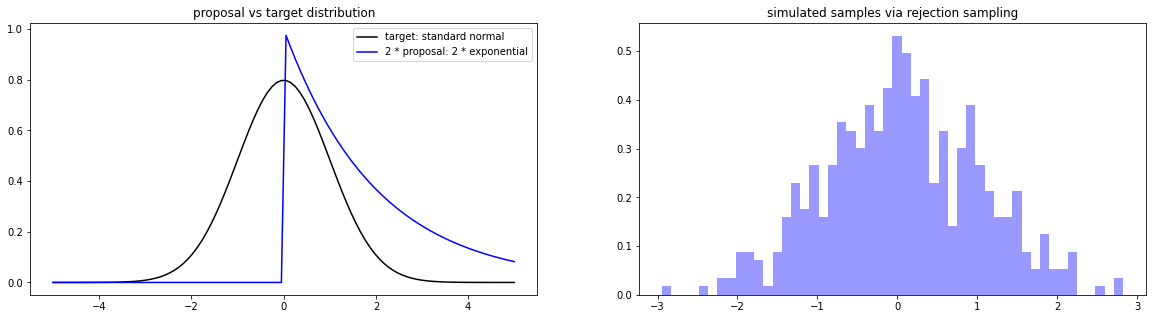

Percent accepted samples = 48.9


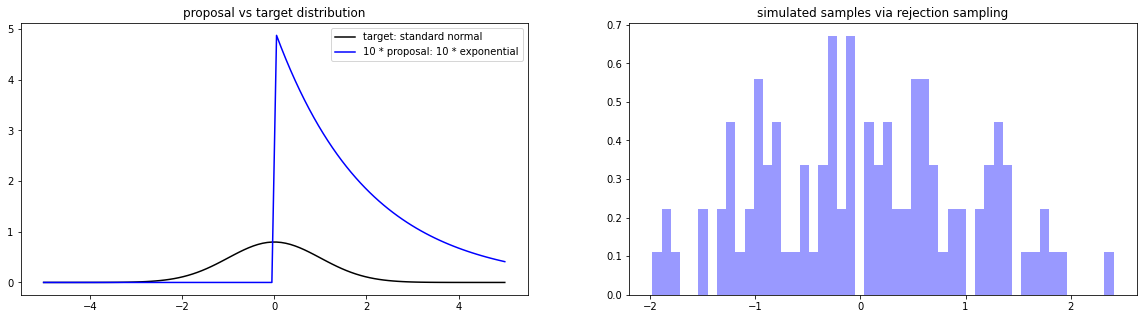

Percent accepted samples = 10.2


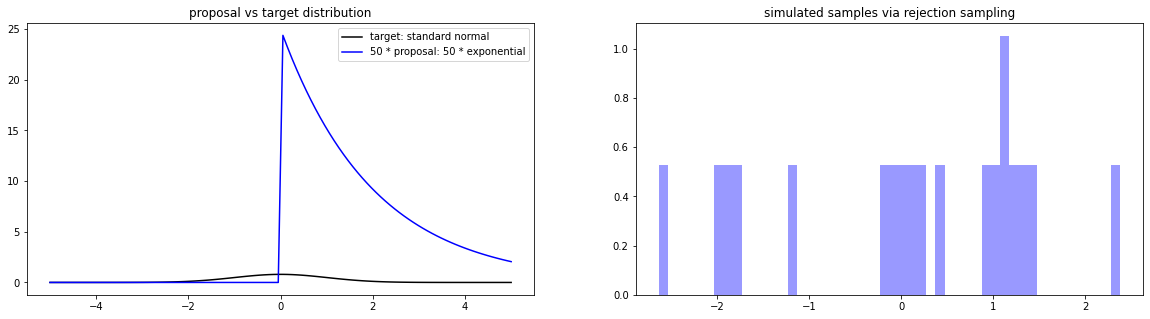

Percent accepted samples = 1.9


In [ ]:
for m in [0.1,0.2,0.5,1,2,10,50]:
  run_rej_sampler(m)


**Answers** 
* M is theoretically valid a 2, 10, 50.
* M=2 gave the best estimate.
* Some M give better estimates, because with them more of the 500 samples are accepted. This occurs when the proposal distribution is above but close to the target distribution.

**Exercise 2:** Implement rejection sampling for the standard univariate normal distribution using a mixture of Gaussian distribution as the proposal distribution. Choose an appropriate value of $M$. Is this proposal distribution better or worse than that in Exercise 1? Why?

Play with the number of mixture components, the means and the variances of the mixture components. What are the best settings for these hyperparameters (mixture components, means and variances)? Why?

In [ ]:
#target distribution
target_pdf = sp.stats.norm(loc=0, scale=1).pdf

#define parameters of mixture of gaussian distribution
pis = [0.25, 0.25, 0.4, 0.1]
mus = [-4, -2, 2, 4]
sigma_sqs = [0.5, 1, 2, 0.2]

#define proposal distribution pdf
def proposal_pdf(sample):
  pdf_val = 0
  for i in range(len(pis)):
    pdf_val += pis[i] * sp.stats.norm(mus[i], sigma_sqs[i]**0.5).pdf(sample)
  return pdf_val

#define the proposal distribution sampler
def proposal_sampler(n_samples):
  component_samples = np.random.choice(np.arange(len(pis)), size=n_samples, p=pis)
  samples = []
  for i in component_samples:
    samples.append(np.random.normal(mus[i], sigma_sqs[i]**0.5, size=1))
  return np.array(samples)

In [ ]:
#scaling constant
M = 10

#total number of samples we want
N = 1000
samples = []
#repeat rejection sampling until total number of samples is attained
for i in range(N):
    #sample x from proposal distribution
    proposed_sample = proposal_sampler(1)[0]
    #sample a random height at x
    u = np.random.uniform(0, 1)
    #accept if height is below target distribution
    #remember that we are comparing the exponential distribution to the right half of the normal pdf
    #so we need to scale the normal pdf by a factor of 2 to make it a proper pdf over the nonnegative numbers
    if u < target_pdf(proposed_sample) / (M * proposal_pdf(proposed_sample)):
        #if we are accepting randomly append a negative sign to the sample
        samples.append(proposed_sample)
        
samples = np.array(samples)

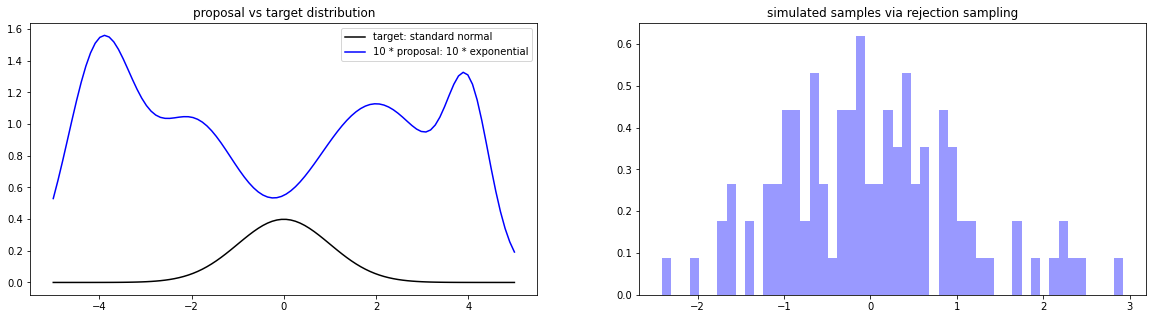

In [ ]:
#plot samples
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
x = np.linspace(-5, 5, 100)
ax[0].plot(x, target_pdf(x), color='black', label='target: standard normal')
ax[0].plot(x, M * proposal_pdf(x), color='blue', label='{} * proposal: {} * exponential'.format(M, M))
ax[0].set_title('proposal vs target distribution')
ax[0].legend(loc='best')
ax[1].hist(samples, bins=50, density=True, color='blue', alpha=0.4)
ax[1].set_title('simulated samples via rejection sampling')
plt.show()   

In [ ]:
# Function to play with sampler
def run_sampler(pis, mus, sigma_sqs, M):
  #scaling constant
  M = M

  #total number of samples we want
  N = 1000
  samples = []
  #repeat rejection sampling until total number of samples is attained
  for i in range(N):
      #sample x from proposal distribution
      proposed_sample = proposal_sampler(1)[0]
      #sample a random height at x
      u = np.random.uniform(0, 1)
      #accept if height is below target distribution
      #remember that we are comparing the exponential distribution to the right half of the normal pdf
      #so we need to scale the normal pdf by a factor of 2 to make it a proper pdf over the nonnegative numbers
      if u < target_pdf(proposed_sample) / (M * proposal_pdf(proposed_sample)):
          #if we are accepting randomly append a negative sign to the sample
          samples.append(proposed_sample)
          
  samples = np.array(samples)
  
  #plot samples
  fig, ax = plt.subplots(1, 2, figsize=(20, 5))
  x = np.linspace(-5, 5, 100)
  ax[0].plot(x, target_pdf(x), color='black', label='target: standard normal')
  ax[0].plot(x, M * proposal_pdf(x), color='blue', label='{} * proposal: {} * exponential'.format(M, M))
  ax[0].set_title('proposal vs target distribution')
  ax[0].legend(loc='best')
  ax[1].hist(samples, bins=50, density=True, color='blue', alpha=0.4)
  ax[1].set_title('simulated samples via rejection sampling')
  plt.show()  
  print(f'Percent accepted samples = {len(samples)/N*100}') 

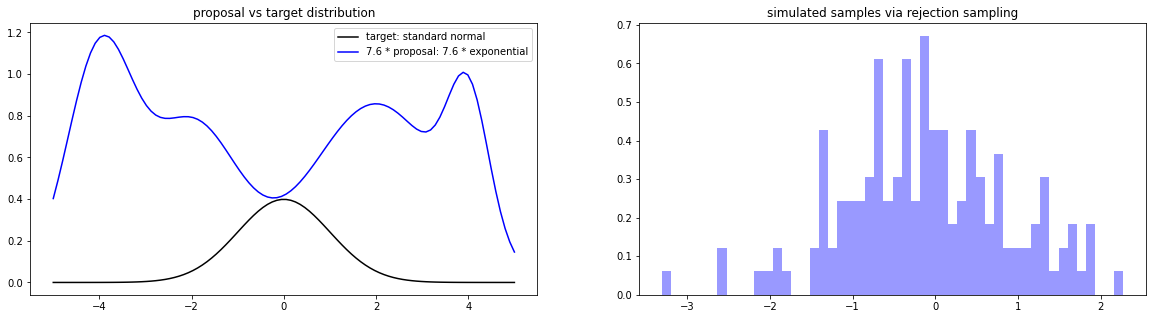

Percent accepted samples = 14.7


In [ ]:
# reducing M
pis = [0.25, 0.25, 0.4, 0.1]
mus = [-4, -2, 2, 4]
sigma_sqs = [0.5, 1, 2, 0.2]
M =7.6

run_sampler(pis, mus, sigma_sqs, M)



**Answer 2.1** The best M we could find is M= 7.6. With this M the proposal function is still not good, as we only get a 12.9 percent acceptance rate. However, it is improved over M = 10 (acceptance rate = 11.3%), because there is less vertical space between the proposal and target distributions when M is reduced. M= 7.6 is the best we can do, because lowering it any further makes it invalid,  as it would goes below the target distribution at ~ x = 0.



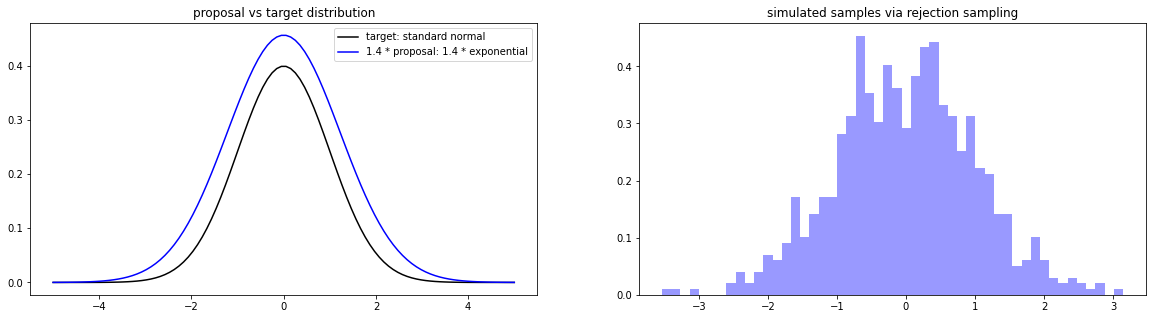

Percent accepted samples = 74.3


In [ ]:
# just using a single gaussian
pis = [1]
mus = [0]
sigma_sqs = [1.5]
M =1.4
run_sampler(pis, mus, sigma_sqs, M)

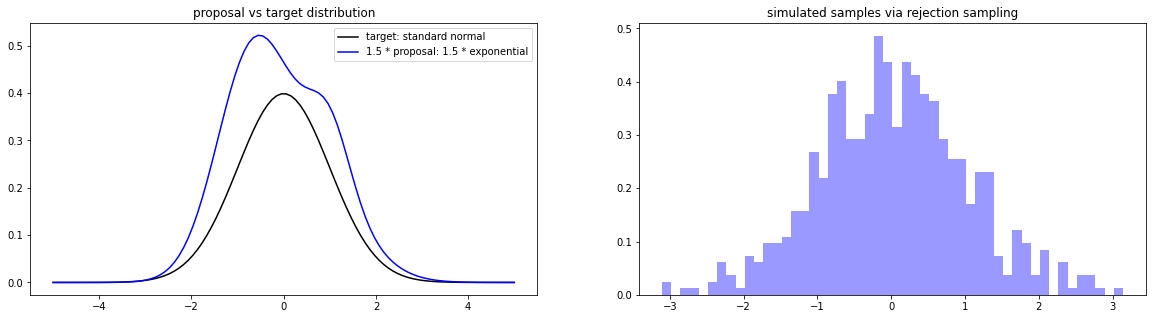

Percent accepted samples = 65.9


In [ ]:
# Best Sampler we found with 4 gaussians,  varying mus,  sigma_sqs and M but holding pis constant.
pis = [0.25, 0.25, 0.4, 0.1]
mus = [-1, -0.5, 0.5, 1]
sigma_sqs = [0.5, .5, 1, 0.2]
M =1.5
run_sampler(pis, mus, sigma_sqs, M)

**Answers 2.2 :** Question: Play with the number of mixture components, the means and the variances of the mixture components. What are the best settings for these hyperparameters (mixture components, means and variances)? Why?

* If we use a single gaussian, we can get the proposal distribution to match closely the target distribution and therefore we get very good sampling.
* If we stick with 4 gaussians, the best parameters we found wihtout varying the pis were as follows: pis = [0.25, 0.25, 0.4, 0.1], mus = [-1, -0.5, 0.5, 1], sigma_sqs = [0.5, .5, 1, 0.2], M =1.5.
* The reason these parameters work well is because they bring the proposal distribution fairly close to the target distribution. The less space between the proposal and target distributions the more samples are accepted.

**Exercise 3:** Now we simulate a standard Gaussian distribution in higher dimensions. We will use a Gaussian distribution that is already extremely similar to our target distribution. Play with a range of dimensions, $D = 1, 5, 0, 50, 100$. What is the effect of the dimensionality of the target distribution on the efficiency of the rejection sampler? Is this expected?

In [ ]:
#dimensionality of distribution
D = 1
#target distribution
target_mu = [0] * D #mean
target_sigma = np.eye(len(target_mu)) #covariance
target_pdf = sp.stats.multivariate_normal(target_mu, target_sigma).pdf
#proposal distirbution
proposal_mu = [0] * D #mean
proposal_sigma = 1.5 * np.eye(len(proposal_mu)) #covariance
proposal_pdf = sp.stats.multivariate_normal(proposal_mu, proposal_sigma).pdf
#scaling constant
M = 2

#total number of iterations of rejection sampling
N = 5000
samples = []
#repeat rejection sampling until total number of samples is attained
for i in range(N):
    #sample x from proposal distribution
    proposed_sample = np.random.multivariate_normal(proposal_mu, proposal_sigma, size=1)
    #sample a random height at x
    u = np.random.uniform(0, 1)
    #accept if height is below target distribution
    #remember that we are comparing the exponential distribution to the right half of the normal pdf
    #so we need to scale the normal pdf by a factor of 2 to make it a proper pdf over the nonnegative numbers
    if u < target_pdf(proposed_sample) / (M * proposal_pdf(proposed_sample)):
        #if we are accepting randomly append a negative sign to the sample
        samples.append(proposed_sample)
        
samples = np.array(samples)

print('number of accepted samples:', len(samples))

number of accepted samples: 2524


In [ ]:
# function to play with sampler
def run_g_sampler(D):
  #dimensionality of distribution
  D = D
  #target distribution
  target_mu = [0] * D #mean
  target_sigma = np.eye(len(target_mu)) #covariance
  target_pdf = sp.stats.multivariate_normal(target_mu, target_sigma).pdf
  #proposal distirbution
  proposal_mu = [0] * D #mean
  proposal_sigma = 1.5 * np.eye(len(proposal_mu)) #covariance
  proposal_pdf = sp.stats.multivariate_normal(proposal_mu, proposal_sigma).pdf
  #scaling constant
  M = 2

  #total number of iterations of rejection sampling
  N = 5000
  samples = []
  #repeat rejection sampling until total number of samples is attained
  for i in range(N):
      #sample x from proposal distribution
      proposed_sample = np.random.multivariate_normal(proposal_mu, proposal_sigma, size=1)
      #sample a random height at x
      u = np.random.uniform(0, 1)
      #accept if height is below target distribution
      #remember that we are comparing the exponential distribution to the right half of the normal pdf
      #so we need to scale the normal pdf by a factor of 2 to make it a proper pdf over the nonnegative numbers
      if u < target_pdf(proposed_sample) / (M * proposal_pdf(proposed_sample)):
          #if we are accepting randomly append a negative sign to the sample
          samples.append(proposed_sample)
          
  samples = np.array(samples)

  print(f'Percent accepted samples: {100*len(samples)/N}, D = {D}')

Percent accepted samples: 48.66, D = 1
Percent accepted samples: 50.9, D = 5
Percent accepted samples: 45.62, D = 10
Percent accepted samples: 23.1, D = 50
Percent accepted samples: 11.0, D = 100


Text(0.5, 0, 'D')

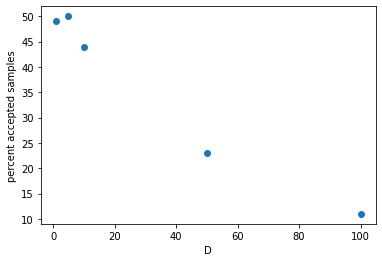

In [ ]:
run_g_sampler(1)
run_g_sampler(5)
run_g_sampler(10)
run_g_sampler(50)
run_g_sampler(100)

plt.scatter([1,5,10, 50, 100],[49, 50, 44, 23, 11] )
plt.ylabel('percent accepted samples')
plt.xlabel('D')

**Answers 3** question: What is the effect of the dimensionality of the target distribution on the efficiency of the rejection sampler? Is this expected?

* As seen in the cell above, as D is increased the percentage of accepted samples decreases. The effect however is not linear, as it falls off not at all between D= 1 and D=5 and then more as D increases but withour a constant slope. 
* This is as exspected as in today's lecture it was stated that the optimal acceptance rate will be $$\frac{1}{M_{optimal}} = \frac{1}{(var_{proposal}/var_{target})^D}$$ which decreases as D increases.

**Exercise 4:** Based on your experiments, comment on the applicability of rejection sampling for sampling from general target distributions.




**Answer 4** 

Rejection sampling can work well when the proposal distribuition follows closely the target distribution, but finding such a proposal distribution will we think in general be difficult, especially in higher dimesions where the proposal and target distributions can not be visualized. So the efficency of rejecting sampling is not likley ot be good in general, and as we found in excercise 3, it gets worse as the dimensionality of the target distribution increases.

---

## Problem 2: Computing Marginal Log-Likelihood

Now that we have a way of sampling from complex posteriors of Bayesian models, we can now compute the marginal log-likelihood (i.e. evaluate the fit of our Bayesian model). 

Recall that when building a Bayesian model for a normally distributed random variable (with unknown mean and known variance), $Y\sim \mathcal{N}(\mu, 1)$, we typically choose a normal prior for the mean, $\mu \sim \mathcal{N}(m, s)$, since this prior is conjugate to the likelihood and thus the posterior (another normal distribution) can be computed in closed form.

**Exercise 5:** Suppose that $Y$ represents the weight of a new born in a population under study. Is a normal prior for $\mu$ appropriate in the context of this application? Why or why not?

Given your choice of distirbutions you've seen in this course: exponential, gamma, poisson, beta, binomial, which is the most appropriate choice for the prior on $\mu$?

**Answers 5** 
* No a normal prior is not appropriate because it allows for $\mu$ to be less than 0, which is not possible for birth weight.

* We chose a gamma prior as its range does not go below 0, but it is unbounded above and can take on a reasonable shape with a peak around near what we expect is the average weight of a newborn ~ 6 pounds.



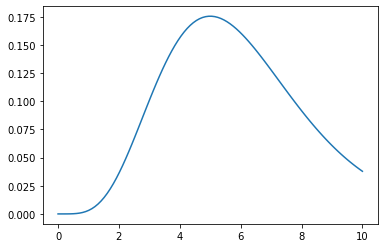

In [ ]:
prior_pdf = sp.stats.gamma(6).pdf 
x = np.linspace(0, 10, 100)
plt.plot(x, prior_pdf(x))
plt.show()

**Exercise 6:** For the Bayesian model
\begin{align}
Y &\sim \mathcal{N}(\mu, 1)\\
\mu &\sim p(\mu),
\end{align}

where $p(\mu)$ is your choice of prior, implement rejection sampling to sample from the posterior of this model. Note that if $p(\mu)$ is not conjugate to the likelihood, you will not be able to compute the normalizing constant of the posterior $\mathcal{Z} = p(\mu | \mathrm{Data})$. Is it necessary for us to know what $\mathcal{Z}$ is in order to implement rejection sampling (think about how would you comput $M$)?

You are provided with an example of a rejection sampler for $p(\mu) = \mathcal{N}(6, 0.5)$. You should alter replace $p(\mu)$ with your chosen prior. The default proposal distribution is $\mathcal{N}(6, 1)$ (we are cheating and centering our proposal distribution at the ground truth data generating mean). Change the mean and variance of the proposal distribution, as well as $M$; change also the number of observations (right now there are only two observations).

How is performance of the sampler impacted by the number of observations, the proposal distribution etc?

Given your experiments, how practical is it to use rejection sampling to perform Bayesian inference (e.g. to sample from posteriors of Bayesian models).

In [ ]:
#generate toy data
N = 2 #number of observations
toy_data = np.random.normal(6, 0.5**2, size=N) #generate toy birth weight data from a normal distribution centered at 6

#target distribution (unnormalized posterior distribution: likelihood times prior)
#prior_pdf = sp.stats.norm(loc=6, scale=0.5**0.5).pdf #prior pdf
prior_pdf = sp.stats.gamma(6).pdf 
x = np.linspace(0, 10, 100)
lkhd_mu = np.array(toy_data) #likelihood mean
lkhd_sigma = np.eye(N) #likelihood covariance
likelihood_pdf = lambda mu: sp.stats.multivariate_normal(lkhd_mu, lkhd_sigma).pdf(mu * np.ones(N)) #likelihood pdf
target_pdf = lambda mu: likelihood_pdf(mu) * prior_pdf(mu) #target distirbution: unnormalized posterior distribution
#proposal distirbution
proposal_pdf = sp.stats.norm(loc=mp, scale=varp*80.5).pdf #the proposal distribution is a normal distribution centered at 6

#scaling constant
M = 0.5

#total number of iterations of rejection sampling
T = 5000
samples = []
#repeat rejection sampling until total number of samples is attained
for i in range(T):
    #sample x from proposal distribution
    proposed_sample = np.random.normal(6, 1., size=1)[0]
    #sample a random height at x
    u = np.random.uniform(0, 1)
    # print(proposed_sample, target_pdf(proposed_sample), M * proposal_pdf(proposed_sample), target_pdf(proposed_sample) / (M * proposal_pdf(proposed_sample)))
    #accept if height is below target distribution
    if u < target_pdf(proposed_sample) / (M * proposal_pdf(proposed_sample)):
        #if we are accepting randomly append a negative sign to the sample
        samples.append(proposed_sample)
        
samples = np.array(samples)

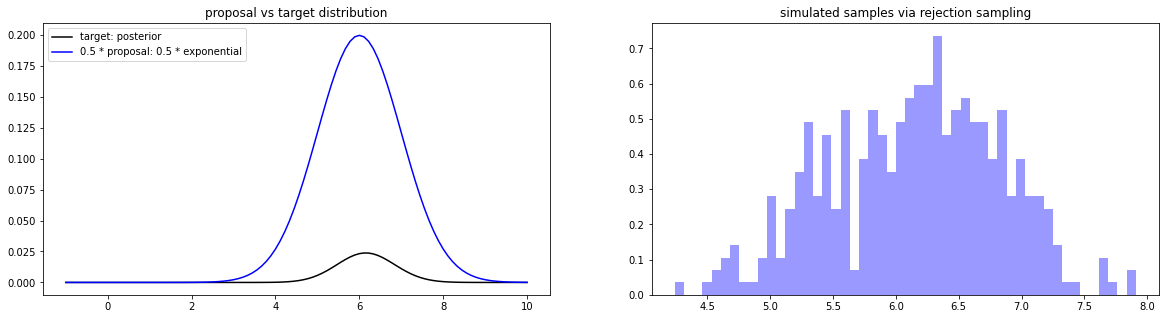

In [ ]:
#plot samples
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
x = np.linspace(-1, 10, 100)
target_pdf_val = [target_pdf(val) for val in x]
ax[0].plot(x, target_pdf_val, color='black', label='target: posterior')
ax[0].plot(x, M * proposal_pdf(x), color='blue', label='{} * proposal: {} * exponential'.format(M, M))
ax[0].set_title('proposal vs target distribution')
ax[0].legend(loc='best')
ax[1].hist(samples, bins=50, density=True, color='blue', alpha=0.4)
ax[1].set_title('simulated samples via rejection sampling')
plt.show() 

In [ ]:
# function to play with sampler
def bayesian_sampler(N, mp, varp, M):
  #generate toy data
  N = N #number of observations
  toy_data = np.random.normal(6, 0.5**2, size=N) #generate toy birth weight data from a normal distribution centered at 6

  #target distribution (unnormalized posterior distribution: likelihood times prior)
  #prior_pdf = sp.stats.norm(loc=6, scale=0.5**0.5).pdf #prior pdf
  prior_pdf = sp.stats.gamma(6).pdf 
  x = np.linspace(0, 10, 100)
  lkhd_mu = np.array(toy_data) #likelihood mean
  lkhd_sigma = np.eye(N) #likelihood covariance
  likelihood_pdf = lambda mu: sp.stats.multivariate_normal(lkhd_mu, lkhd_sigma).pdf(mu * np.ones(N)) #likelihood pdf
  target_pdf = lambda mu: likelihood_pdf(mu) * prior_pdf(mu) #target distirbution: unnormalized posterior distribution
  #proposal distirbution
  proposal_pdf = sp.stats.norm(loc=mp, scale=varp**0.5).pdf #the proposal distribution is a normal distribution centered at 6

  #scaling constant
  M = M

  #total number of iterations of rejection sampling
  T = 5000
  samples = []
  #repeat rejection sampling until total number of samples is attained
  for i in range(T):
      #sample x from proposal distribution
      proposed_sample = np.random.normal(6, 1., size=1)[0]
      #sample a random height at x
      u = np.random.uniform(0, 1)
      # print(proposed_sample, target_pdf(proposed_sample), M * proposal_pdf(proposed_sample), target_pdf(proposed_sample) / (M * proposal_pdf(proposed_sample)))
      #accept if height is below target distribution
      if u < target_pdf(proposed_sample) / (M * proposal_pdf(proposed_sample)):
          #if we are accepting randomly append a negative sign to the sample
          samples.append(proposed_sample)
        
  samples = np.array(samples)

  #plot samples
  fig, ax = plt.subplots(1, 2, figsize=(20, 5))
  x = np.linspace(-1, 10, 100)
  target_pdf_val = [target_pdf(val) for val in x]
  ax[0].plot(x, target_pdf_val, color='black', label='target: posterior')
  ax[0].plot(x, M * proposal_pdf(x), color='blue', label='{} * proposal: {} * exponential'.format(M, M))
  ax[0].set_title('proposal vs target distribution')
  ax[0].legend(loc='best')
  ax[1].hist(samples, bins=50, density=True, color='blue', alpha=0.4)
  ax[1].set_title('simulated samples via rejection sampling')
  plt.show() 
  print(f'Percent accepted samples: {100*len(samples)/T} N={N}, mp={mp}, varp={varp}, M={M}')

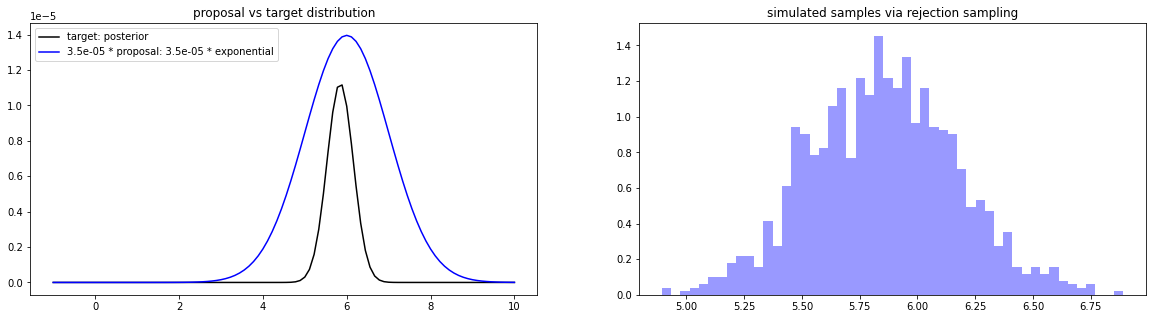

Percent accepted samples: 25.5 N=10, mp=6, varp=1, M=3.5e-05


In [ ]:
bayesian_sampler(N=10, mp=6, varp=1, M=0.000035)

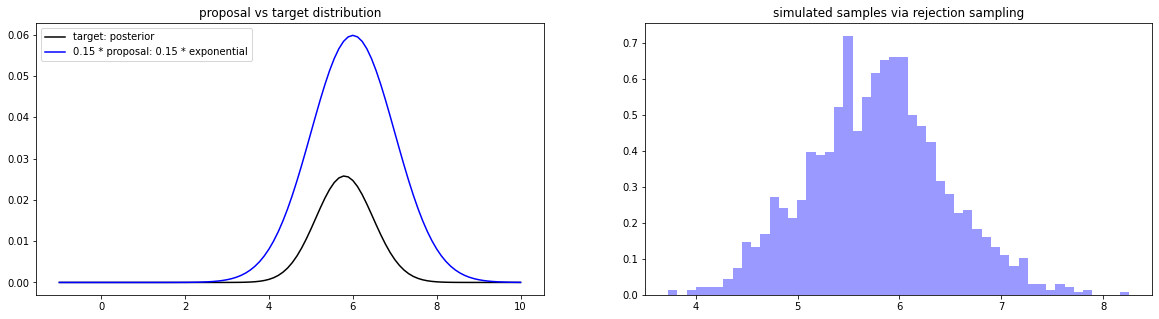

Percent accepted samples: 30.1 N=2, mp=6, varp=1, M=0.15


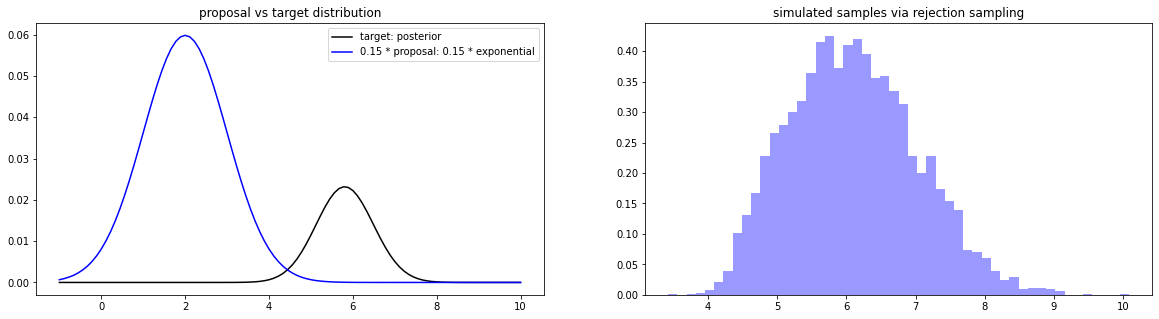

Percent accepted samples: 95.66 N=2, mp=2, varp=1, M=0.15


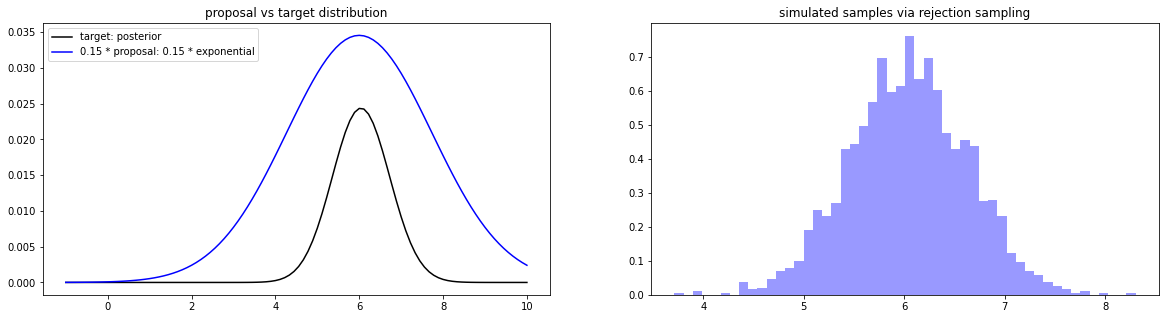

Percent accepted samples: 41.26 N=2, mp=6, varp=3, M=0.15


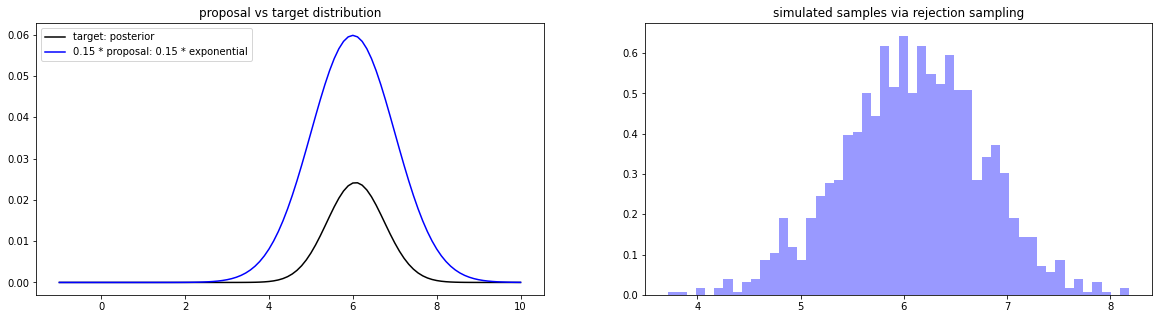

Percent accepted samples: 28.2 N=2, mp=6, varp=1, M=0.15


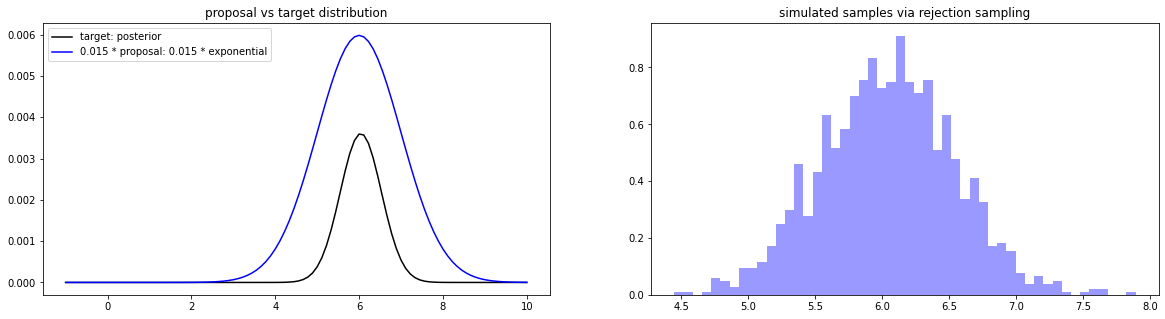

Percent accepted samples: 30.3 N=4, mp=6, varp=1, M=0.015


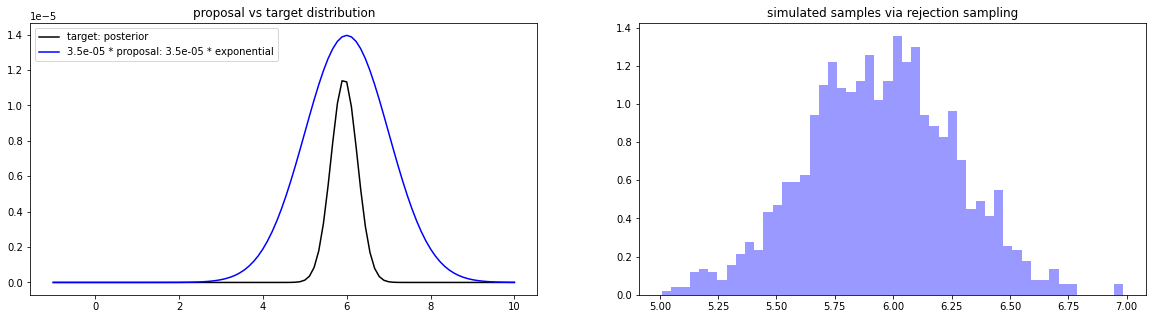

Percent accepted samples: 25.76 N=10, mp=6, varp=1, M=3.5e-05


In [ ]:
bayesian_sampler(N=2, mp=6, varp=1, M=0.15)
bayesian_sampler(N=2, mp=2, varp=1, M=0.15)
bayesian_sampler(N=2, mp=6, varp=3, M=0.15)
bayesian_sampler(N=2, mp=6, varp=1, M=0.15)
bayesian_sampler(N=4, mp=6, varp=1, M=0.015)
bayesian_sampler(N=10, mp=6, varp=1, M=0.000035)

**Answers 6** Questions: How is performance of the sampler impacted by the number of observations, the proposal distribution etc?

* As the numbner of data points increases the likelihoods of the data greatly decrease such that one must lower M a great deal for the sampler to work at all well.

Question: Given your experiments, how practical is it to use rejection sampling to perform Bayesian inference (e.g. to sample from posteriors of Bayesian models).

* In general it will not be feasible, as it will be very hard to find an appropriate M in higher dimensions (where visuyalization is impossible) that will yield and efficient sampler.



**Exercise 7:** Use your sampler to compute the marginal data log-likelihood and evaluate the fit of your model on a set of observed data. 

Given a set of observed data, $y_1, \ldots, y_N$, and a set of test data $y^*_1, \ldots, y^*_M$, recall that the marginal data log-likelihood is computed as:

\begin{align}
\log \prod_{m=1}^M p(y^*_m | \textrm{Data}) &= \sum_{m=1}^M \log p(y^*_m | \textrm{Data}),\\
&= \sum_{m=1}^M \log \mathbb{E}_{p(\mu|\mathrm{Data})} p(y^*|\mu)\\
&\approx \sum_{m=1}^M \log \frac{1}{S}\sum_{s=1}^S p(y^*|\mu_s), \quad \mu_s \sim p(\mu|\mathrm{Data})
\end{align}

***Implementation note:*** In practice, is always recommended that you implement the approximation of the marginal data log-likelihood as

\begin{align}
\log \prod_{m=1}^M p(y^*_m | \textrm{Data}) &\approx \sum_{m=1}^M \log \frac{1}{S}\sum_{s=1}^S p(y^*|\mu_s), \quad \mu_s \sim p(\mu|\mathrm{Data})\\
&= \sum_{m=1}^M \log\frac{1}{S} + \sum_{m=1}^M \underbrace{\log \sum_{s=1}^S \mathrm{exp}}_{\texttt{log-sum-exp function}}\{ \log p(y^*|\mu_s)\}, \quad \mu_s \sim p(\mu|\mathrm{Data}).
\end{align}
where the $\log \sum_{s=1}^S \mathrm{exp}$ portion of the expression is computed using `scipy`'s `logsumexp` function. 

Why is this necessary?

In [ ]:
#marginal data log-likelihood without the log-sum-exp trick
marginal_lkhd = 0
for y in toy_data:
  marginal_lkhd += np.mean([sp.stats.norm(loc=mu_s, scale=1.).pdf(y) for mu_s in samples])

print('the marginal data log-likelihood of the data is:', marginal_lkhd)

the marginal data log-likelihood of the data is: 0.6516131780386395
